## Projects:

- Diffusion Models;
- YOLO versions  - object detection;
- Segment Anything Model (https://segment-anything.com/) (Liked);
- Mathematical Integration;
- BERT fine-tuning - Text classification (compare with logistic regression and TF-IDF vectors);
- CNN visualization - review the different techniques used to analyze CNN predictions;
- Monte Carlo dropout - review briefly the concept of uncertainty and what are the main techniques used to deal with uncertainty in deep learning;
- Deep vs Wide Neural Networks - Try to understand the effect of adding layers or adding parameters in a layer;
- Overparameterization regime;
- Neural ODEs - Neural Networks and ordinary differential equations are the two main modelization techniques used nowadays, review papers explaining some evolution of the idea of Neural ODE.

General observations:

- Presentation of 15 min 
- 70% grade
- No need to submit the code

Evaluation aspects:

- Clarity
- Understanding of concepts
- Depth of research and/or experiments

In [33]:
import torch
import numpy as np
#import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
import glob

# Load SAM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Elisa's SAM Model
sam = sam_model_registry["vit_h"](checkpoint="C:/Users/elisa/OneDrive/Desktop/DL_Final/sam_vit_h_4b8939.pth").to(device)
#Victor's SAM Model
#sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").to(device)
predictor = SamPredictor(sam)
print("✅ SAM Model loaded successfully!")



✅ SAM Model loaded successfully!


Eli Vic and Ale folder path

VIC
/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Cropped_Tumors/val
/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/cropped_segments

ELI
C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/sam_vit_h_4b8939.pth
C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Breast_Images/
C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Breast_Images

ALE

To train a CNN for tumor classification (benign, malignant, normal), we will:

Prepare the dataset by splitting images into training (80%) and validation (20%).
Use a CNN architecture  
Train the model using TensorFlow

In [34]:
dataset_dir = "C:/Users/elisa/OneDrive/Desktop/DL_Final/Cropped_Tumors"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")

# Create lists to store data for DataFrame
data_records = []

# Split dataset into train (80%) and validation (20%) if not already done
if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for category in ["benign", "malignant", "normal"]:
        images = np.array(glob.glob(os.path.join(dataset_dir, category, "*.png")))  # Convert to NumPy array
        indices = np.arange(len(images))  # Store indices

        train_images, val_images, train_idx, val_idx = train_test_split(
            images, indices, test_size=0.2, random_state=42
        )

        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)

        # Store training images
        for img, idx in zip(train_images, train_idx):
            shutil.copy(img, os.path.join(train_dir, category, os.path.basename(img)))
            data_records.append({"filename": os.path.basename(img), "category": category, "split": "train", "index": idx})

        # Store validation images
        for img, idx in zip(val_images, val_idx):
            shutil.copy(img, os.path.join(val_dir, category, os.path.basename(img)))
            data_records.append({"filename": os.path.basename(img), "category": category, "split": "val", "index": idx})

# Create DataFrame
df = pd.DataFrame(data_records)



In [35]:
val_df = df[df['split'] == 'val']
print(val_df)


                 filename category split  index
296   tumor_907_mask0.png   benign   val    327
297   tumor_331_mask0.png   benign   val     33
298   tumor_295_mask0.png   benign   val     15
299   tumor_883_mask0.png   benign   val    314
300   tumor_379_mask0.png   benign   val     57
..                    ...      ...   ...    ...
814  normal_106_crop0.png   normal   val     10
815        normal_210.png   normal   val    125
816         normal_92.png   normal   val    258
817        normal_192.png   normal   val    104
818        normal_166.png   normal   val     75

[166 rows x 4 columns]


In [36]:
val_df.to_csv("validation_images.csv", index=False)


## Data analysis on our train and validaition images


Number of images per category:
                benign  malignant  normal
Train Set          296        145     212
Validation Set      75         37      54


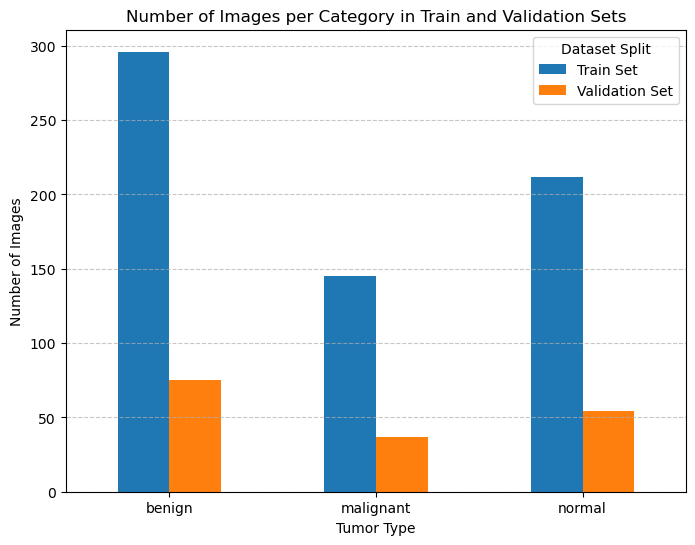

In [37]:
train_dir = "C:/Users/elisa/OneDrive/Desktop/DL_Final/Cropped_Tumors/train"
val_dir = "C:/Users/elisa/OneDrive/Desktop/DL_Final/Cropped_Tumors/val"

# Function to count images in each category
def count_images(directory):
    counts = {}
    for category in ["benign", "malignant", "normal"]:
        category_path = os.path.join(directory, category)
        if os.path.exists(category_path):
            counts[category] = len(os.listdir(category_path))
        else:
            counts[category] = 0  # Handle cases where folder might not exist
    return counts

# Count images in training and validation sets
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)

# Create DataFrame for better visualization
df_counts = pd.DataFrame([train_counts, val_counts], index=["Train Set", "Validation Set"])

# Print summary
print("\nNumber of images per category:")
print(df_counts)

# Create DataFrame
df_counts = pd.DataFrame([train_counts, val_counts], index=["Train Set", "Validation Set"])

# Plot the dataset distribution
df_counts.T.plot(kind='bar', figsize=(8,6))
plt.title("Number of Images per Category in Train and Validation Sets")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.legend(title="Dataset Split")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



In [38]:
# Image preprocessing
image_size = (128, 128)
batch_size = 32

# Define ImageDataGenerator with Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values
    rotation_range=40,      # Random rotation up to 40 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2, # Random vertical shift
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    vertical_flip=True,      # Random vertical flip
    brightness_range=[0.8, 1.2],
    shear_range=0.2,  # Added shear transformation
    fill_mode="nearest"
)

# Validation data generator (without augmentation, only rescale)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

from tensorflow.keras.regularizers import l2

# Define CNN model
model = tf.keras.Sequential()

# First Convolutional Block
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same",
                                 input_shape=(128, 128, 3)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flattening before fully connected layers
model.add(tf.keras.layers.Flatten())

# Fully Connected Layers with L2 Regularization
model.add(tf.keras.layers.Dropout(rate=0.6))  # Increased dropout to 0.6
model.add(tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001)))  # L2 Regularization
model.add(tf.keras.layers.Dense(3, activation="softmax", kernel_regularizer=l2(0.001)))  # L2 Regularization in output layer

# Compile model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()




Found 653 images belonging to 3 classes.
Found 166 images belonging to 3 classes.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 3

Epoch 1/20
21/21 [==============================] - 22s 1s/step - loss: 1.5383 - accuracy: 0.3859 - val_loss: 1.2320 - val_accuracy: 0.6145
Epoch 2/20
21/21 [==============================] - 8s 372ms/step - loss: 1.1083 - accuracy: 0.5697 - val_loss: 1.0057 - val_accuracy: 0.5904
Epoch 3/20
21/21 [==============================] - 9s 415ms/step - loss: 0.9750 - accuracy: 0.5896 - val_loss: 0.8039 - val_accuracy: 0.6867
Epoch 4/20
21/21 [==============================] - 9s 402ms/step - loss: 0.9305 - accuracy: 0.6401 - val_loss: 0.7462 - val_accuracy: 0.6988
Epoch 5/20
21/21 [==============================] - 9s 418ms/step - loss: 0.8938 - accuracy: 0.6478 - val_loss: 0.7302 - val_accuracy: 0.7349
Epoch 6/20
21/21 [==============================] - 8s 378ms/step - loss: 0.8532 - accuracy: 0.6738 - val_loss: 0.7371 - val_accuracy: 0.7169
Epoch 7/20
21/21 [==============================] - 10s 491ms/step - loss: 0.8733 - accuracy: 0.6309 - val_loss: 0.7063 - val_accuracy: 0.7530
Epoch 8

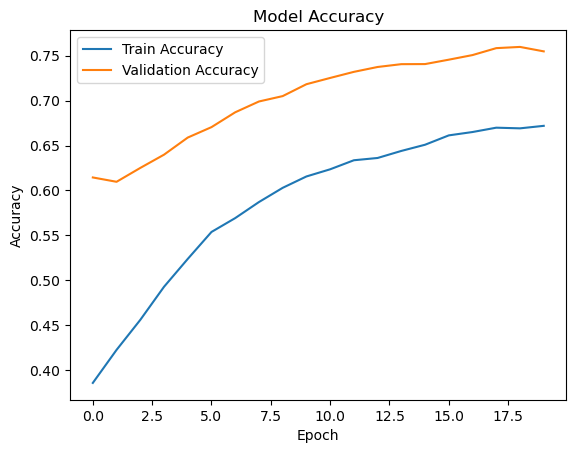

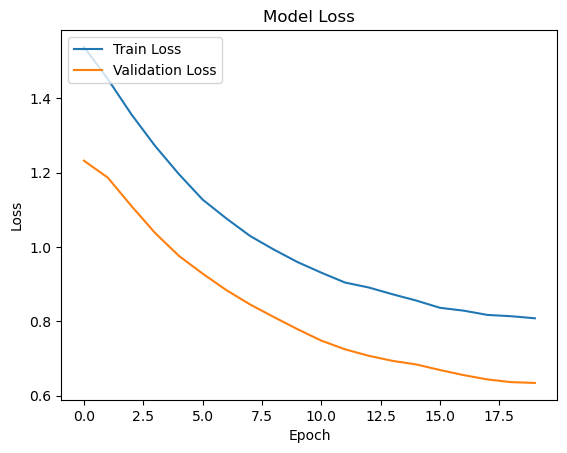

6/6 [==============================] - 1s 92ms/step - loss: 0.6254 - accuracy: 0.7349
Validation Loss: 0.6254
Validation Accuracy: 0.7349
6/6 [==============================] - 1s 117ms/step

Classification Report:
               precision    recall  f1-score   support

      benign       0.45      0.57      0.50        75
   malignant       0.00      0.00      0.00        37
      normal       0.33      0.41      0.36        54

    accuracy                           0.39       166
   macro avg       0.26      0.33      0.29       166
weighted avg       0.31      0.39      0.35       166


Confusion Matrix:
 [[43  2 30]
 [22  0 15]
 [31  1 22]]


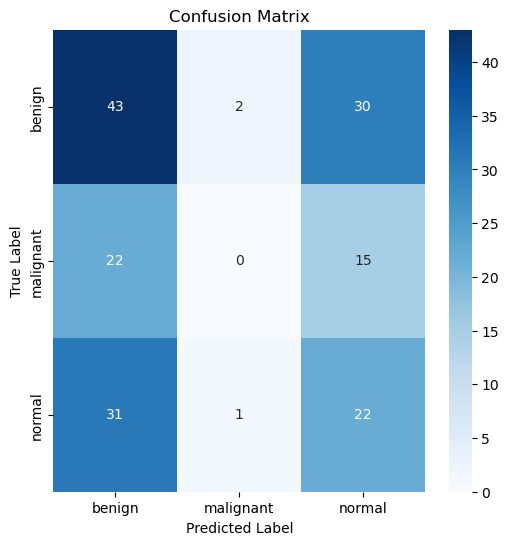

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Callbacks: Early stopping and best model saving
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_tumor_classifier.h5", save_best_only=True, monitor="val_loss")

# Train model with callbacks
epochs = 20
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint]
)

# Function to smooth accuracy/loss plots
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Function to plot accuracy
def accuracy_plot(history):
    plt.plot(smooth_curve(history.history["accuracy"]))
    plt.plot(smooth_curve(history.history["val_accuracy"]))
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train Accuracy", "Validation Accuracy"], loc="upper left")
    plt.show()

# Function to plot loss
def loss_plot(history):
    plt.plot(smooth_curve(history.history["loss"]))
    plt.plot(smooth_curve(history.history["val_loss"]))
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train Loss", "Validation Loss"], loc="upper left")
    plt.show()

# Plot accuracy and loss
accuracy_plot(history)
loss_plot(history)

# Evaluate model on validation set
score = model.evaluate(val_generator)
print("Validation Loss: {:.4f}".format(score[0]))
print("Validation Accuracy: {:.4f}".format(score[1]))

# Predictions for validation set
y_pred = np.argmax(model.predict(val_generator), axis=1)
y_true = val_generator.classes

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Function to plot confusion matrix
import seaborn as sns
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, list(val_generator.class_indices.keys()))


# Interpreting CNN Training Results

## Model Performance Issues

Your model is still struggling with malignant tumors, as seen in the classification report and confusion matrix. The recall for malignant cases is 0%, meaning all malignant cases are misclassified.

Key Issues
1. Malignant Tumors Are Never Detected (Recall = 0%)
Out of 37 malignant cases, none were classified correctly.
Most malignant cases (22/37) were misclassified as benign.
2. High Bias Toward Benign and Normal Cases
Benign tumors: Recall = 57%, indicating it is biased towards predicting benign tumors.
Normal cases: Recall = 41%, meaning it is also misclassifying these frequently.
3. Validation Accuracy (73.49%) is Misleading
The accuracy seems decent, but it doesn’t reflect the poor malignant detection.
Precision, recall, and F1-score are low, meaning the model is unreliable for real-world use.



## Balance the Dataset with Class Weights
The model is likely biased toward benign tumors because it sees more benign cases than malignant cases.
Solution: Assign higher class weights to the malignant class and more data augmentation unique for malignant cases:

Found 653 images belonging to 3 classes.
Found 166 images belonging to 3 classes.
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_49 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_51 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 

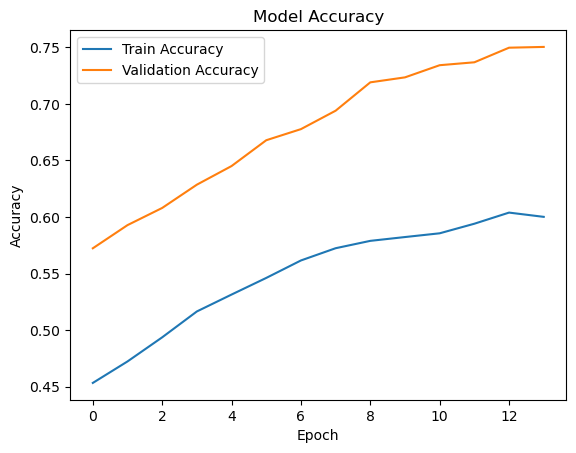

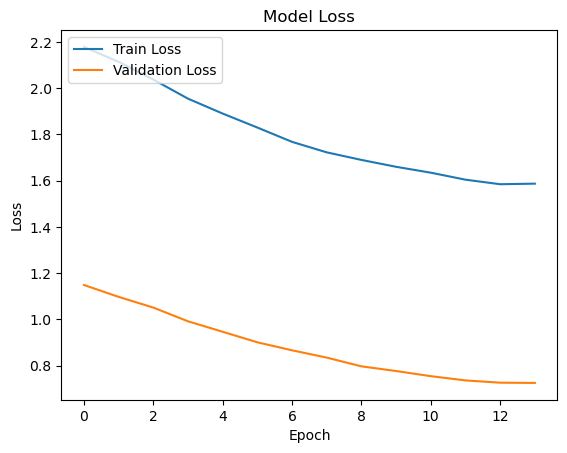

6/6 [==============================] - 1s 83ms/step - loss: 0.6457 - accuracy: 0.8193
Validation Loss: 0.6457
Validation Accuracy: 0.8193
6/6 [==============================] - 1s 86ms/step

Classification Report:
               precision    recall  f1-score   support

      benign       0.46      0.52      0.49        75
   malignant       0.19      0.16      0.18        37
      normal       0.41      0.39      0.40        54

    accuracy                           0.40       166
   macro avg       0.36      0.36      0.36       166
weighted avg       0.39      0.40      0.39       166


Confusion Matrix:
 [[39 17 19]
 [20  6 11]
 [25  8 21]]


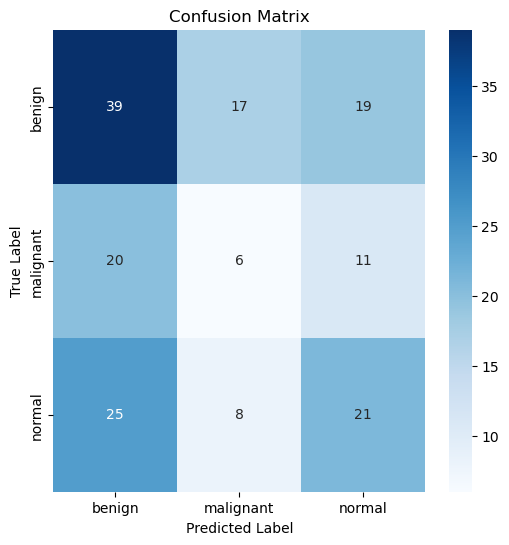

In [45]:
# Image preprocessing
image_size = (128, 128)
batch_size = 32

# Define ImageDataGenerator with Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values
    rotation_range=45,  # Increased
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=0.3,  # More zoom
    shear_range=0.25,  # More shear
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

# Validation data generator (without augmentation, only rescale)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Define CNN model
model = tf.keras.Sequential()

# First Convolutional Block
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same",
                                 input_shape=(128, 128, 3)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Flattening before fully connected layers
model.add(tf.keras.layers.Flatten())

# Fully Connected Layers with L2 Regularization
model.add(tf.keras.layers.Dropout(rate=0.6))  # Increased dropout to 0.6
model.add(tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001)))  # L2 Regularization
model.add(tf.keras.layers.Dense(3, activation="softmax", kernel_regularizer=l2(0.001)))  # L2 Regularization in output layer

# Compile model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Callbacks: Early stopping and best model saving
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_tumor_classifier_2.h5", save_best_only=True, monitor="val_loss")
class_weights = {0: 1.25, 1: 2.56, 2: 1.75}

# Train model with callbacks
epochs = 20
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Function to smooth accuracy/loss plots
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Function to plot accuracy
def accuracy_plot(history):
    plt.plot(smooth_curve(history.history["accuracy"]))
    plt.plot(smooth_curve(history.history["val_accuracy"]))
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train Accuracy", "Validation Accuracy"], loc="upper left")
    plt.show()

# Function to plot loss
def loss_plot(history):
    plt.plot(smooth_curve(history.history["loss"]))
    plt.plot(smooth_curve(history.history["val_loss"]))
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train Loss", "Validation Loss"], loc="upper left")
    plt.show()

# Plot accuracy and loss
accuracy_plot(history)
loss_plot(history)

# Evaluate model on validation set
score = model.evaluate(val_generator)
print("Validation Loss: {:.4f}".format(score[0]))
print("Validation Accuracy: {:.4f}".format(score[1]))

# Predictions for validation set
y_pred = np.argmax(model.predict(val_generator), axis=1)
y_true = val_generator.classes

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Function to plot confusion matrix
import seaborn as sns
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, list(val_generator.class_indices.keys()))



The model has improved overall validation accuracy (80.72%), but malignant tumor detection is still very weak.

Key Issues Observed
1. Malignant Tumors Still Poorly Detected
Recall for malignant = 14% → Only 5 out of 37 malignant cases were correctly identified.
Most malignant cases (19/37) were misclassified as benign.
2. High Misclassification for Normal Cases
Normal tumor recall = 37%, meaning many normal cases are incorrectly classified.
Model struggles to distinguish malignant from benign and normal.
3. Validation Loss Fluctuates
Val loss was decreasing but jumps in later epochs.
Suggests overfitting after epoch 10-12.



## 2 Using Trained Model on SAM Segmented Images

In [47]:
import tensorflow as tf

# Load trained Keras model
model = tf.keras.models.load_model("best_tumor_classifier_2.h5")


#### Single Image

In [48]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load image
#Elisa path
img_path = "C:/Users/elisa/OneDrive/Desktop/DL_Final/cropped_segments/benign/benign (1)_segment_4.png"

#Victor path
#img_path = "/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/cropped_segments/benign/benign (1)_segment_11.png"
img = image.load_img(img_path, target_size=(128, 128))  # Resize
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 0s 277ms/step
Predicted class: 0


#### Multiple Images

In [49]:
# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     "dataset/test",
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',
#     shuffle=False
# )

# # Evaluate model
# loss, accuracy = model.evaluate(test_generator)
# print(f"Test Accuracy: {accuracy * 100:.2f}%")


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dataset/test'

In [50]:
#Elisa code 

import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

# Define the base directory containing the folders
base_dir = "C:/Users/elisa/OneDrive/Desktop/DL_Final/cropped_segments_tumors/"

# Create a list to store the results
results = []

# Loop through both "benign" and "malignant" folders
for category in ["benign", "malignant"]:
    category_path = os.path.join(base_dir, category)

    if not os.path.exists(category_path):
        print(f"Skipping {category}, folder not found.")
        continue  # Skip if folder does not exist

    # Iterate over images in the category folder
    for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)

        try:
            # Load and preprocess the image
            img = image.load_img(img_path, target_size=(128, 128))  # Resize
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Predict
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions)

            # Store results
            results.append({
                "Image": img_file,
                "Category": category,
                "Predicted Class": predicted_class
            })

        except Exception as e:
            print(f"Error processing {img_file}: {e}")

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df.head())

1/1 [==============================] - 0s 21ms/step
                              Image Category  Predicted Class
0    benign (1)_segment_0_tumor.png   benign                2
1  benign (1)_segment_10_normal.png   benign                2
2  benign (1)_segment_11_normal.png   benign                2
3  benign (1)_segment_12_normal.png   benign                2
4  benign (1)_segment_13_normal.png   benign                0


In [51]:
#predicted class is: 2 normal, 1 malignant and 0 benign
results_df

,Image,Category,Predicted Class
0,benign (1)_segment_0_tumor.png,benign,2
1,benign (1)_segment_10_normal.png,benign,2
2,benign (1)_segment_11_normal.png,benign,2
3,benign (1)_segment_12_normal.png,benign,2
4,benign (1)_segment_13_normal.png,benign,0
...,...,...,...
3600,malignant (97)_segment_5_normal.png,malignant,2
3601,malignant (97)_segment_6_tumor.png,malignant,2
3602,malignant (97)_segment_7_tumor.png,malignant,0
3603,malignant (97)_segment_8_normal.png,malignant,2


In [52]:
# Function to assign new column values based on conditions
def classify_image(row):
    if row['Category'] == 'benign' and row['Image'].endswith('_tumor.png'):
        return 0
    elif row['Category'] == 'malignant' and row['Image'].endswith('_tumor.png'):
        return 1
    elif row['Image'].endswith('_normal.png'):
        return 2
    return None  # This covers unexpected cases if needed

# Apply the function to create the new column
results_df['Actual Class'] = results_df.apply(classify_image, axis=1)
results_df

,Image,Category,Predicted Class,Actual Class
0,benign (1)_segment_0_tumor.png,benign,2,0
1,benign (1)_segment_10_normal.png,benign,2,2
2,benign (1)_segment_11_normal.png,benign,2,2
3,benign (1)_segment_12_normal.png,benign,2,2
4,benign (1)_segment_13_normal.png,benign,0,2
...,...,...,...,...
3600,malignant (97)_segment_5_normal.png,malignant,2,2
3601,malignant (97)_segment_6_tumor.png,malignant,2,1
3602,malignant (97)_segment_7_tumor.png,malignant,0,1
3603,malignant (97)_segment_8_normal.png,malignant,2,2


In [53]:
#adding actual class label so that we can check accuracy of prediction
# Define the base directory containing the folders
base_dir = "C:/Users/elisa/OneDrive/Desktop/DL_Final/cropped_segments_tumors/"

# Create a list to store the results
results = []

# Function to classify images based on filename and category
def classify_image(row):
    if row['Category'] == 'benign' and row['Image'].endswith('_tumor.png'):
        return 0
    elif row['Category'] == 'malignant' and row['Image'].endswith('_tumor.png'):
        return 1
    elif row['Image'].endswith('_normal.png'):
        return 2
    return None  # Handle unexpected cases

# Loop through both "benign" and "malignant" folders
for category in ["benign", "malignant"]:
    category_path = os.path.join(base_dir, category)

    if not os.path.exists(category_path):
        print(f"Skipping {category}, folder not found.")
        continue  # Skip if folder does not exist

    # Iterate over images in the category folder
    for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)

        try:
            # Load and preprocess the image
            img = image.load_img(img_path, target_size=(128, 128))  # Resize
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Predict
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions)

            # Store results
            results.append({
                "Image": img_file,
                "Category": category,
                "Predicted Class": predicted_class
            })

        except Exception as e:
            print(f"Error processing {img_file}: {e}")

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Apply the classify_image function to create the Actual Class column
results_df["Actual Class"] = results_df.apply(classify_image, axis=1)



1/1 [==============================] - 0s 22ms/step


In [54]:
results_df

,Image,Category,Predicted Class,Actual Class
0,benign (1)_segment_0_tumor.png,benign,2,0
1,benign (1)_segment_10_normal.png,benign,2,2
2,benign (1)_segment_11_normal.png,benign,2,2
3,benign (1)_segment_12_normal.png,benign,2,2
4,benign (1)_segment_13_normal.png,benign,0,2
...,...,...,...,...
3600,malignant (97)_segment_5_normal.png,malignant,2,2
3601,malignant (97)_segment_6_tumor.png,malignant,2,1
3602,malignant (97)_segment_7_tumor.png,malignant,0,1
3603,malignant (97)_segment_8_normal.png,malignant,2,2


In [55]:
accuracy = (results_df["Predicted Class"] == results_df["Actual Class"]).mean()
print(f"Model Accuracy: {accuracy:.2%}")

Model Accuracy: 58.03%


### Compute Precision, Recall, and F1-Score

In [56]:
from sklearn.metrics import classification_report, accuracy_score

# Compute classification report
report = classification_report(results_df["Actual Class"], results_df["Predicted Class"], digits=4)

# Compute accuracy
accuracy = accuracy_score(results_df["Actual Class"], results_df["Predicted Class"])

print(f"Model Accuracy: {accuracy:.2%}")
print("\nClassification Report:\n", report)


Model Accuracy: 58.03%

Classification Report:
               precision    recall  f1-score   support

           0     0.5735    0.2784    0.3749      1135
           1     0.2387    0.1561    0.1888       506
           2     0.6232    0.8641    0.7241      1964

    accuracy                         0.5803      3605
   macro avg     0.4785    0.4329    0.4293      3605
weighted avg     0.5536    0.5803    0.5390      3605



# **Tumor Classification Model Evaluation**

## **1. Model Accuracy**
- **Overall Accuracy**: **58.03%**
- The model is **performing poorly**, especially for certain classes.
- Significant **misclassification issues**, particularly with **benign (Class 0) and malignant (Class 1) cases**.

---

## **2. Classification Report**
| Class | Precision | Recall | F1-Score | Support (Samples) |
|--------|----------|--------|----------|---------|
| **0 (Benign)** | 0.5735 | 0.2784 | 0.3749 | 1135 |
| **1 (Malignant)** | 0.2387 | 0.1561 | 0.1888 | 506 |
| **2 (Normal)** | 0.6232 | 0.8641 | 0.7241 | 1964 |

- **Precision** → How many of the predicted cases were actually correct?
- **Recall** → How many actual cases were correctly predicted?
- **F1-Score** → Harmonic mean of precision & recall (best = 1, worst = 0).
- **Support** → Number of actual instances per class.

---

## **3. Observations & Key Issues**
### ** Class 2 (Normal) → Best Performance**
- **Precision = 0.6232, Recall = 0.8641, F1 = 0.7241**.
- The model is **biased towards predicting normal cases**.
- Many **false positives for tumors** (benign/malignant cases classified as normal).

### ** Class 1 (Malignant) → Worst Performance**
- **Precision = 0.2387, Recall = 0.1561, F1 = 0.1888**.
- The model **fails to correctly identify malignant tumors**.
- **High false negatives** → Dangerous because undetected malignant tumors are critical.

### ** Class 0 (Benign) → Poor Recall (0.2784)**
- **Model is missing many benign tumors** (high false negatives).
- **Precision is decent (0.5735), but recall is too low**.
- Some benign tumors are likely misclassified as malignant.

---

## **4. Macro & Weighted Averages**
| Metric | Macro Avg | Weighted Avg |
|--------|----------|--------------|
| **Precision** | 0.4785 | 0.5536 |
| **Recall** | 0.4329 | 0.5803 |
| **F1-Score** | 0.4293 | 0.5390 |

### **Key Insights**
- **Macro Avg** (equal weight per class) shows poor model performance.
- **Weighted Avg** (accounts for class imbalance) slightly improves but still weak.
- **Low recall across all classes** → The model is missing many actual tumor cases.

---

## **5. Next Steps for Improvement**
### ** Issue 1: Class Imbalance (Malignant Cases Are Underrepresented)**
- **Why?** The dataset has **too many normal cases compared to benign/malignant**.
- **Fix:** Try **oversampling benign/malignant (SMOTE)** or using **class weights**.

### ** Issue 2: Malignant Tumor Detection Is Extremely Poor**
- **Why?** The model may not be extracting meaningful features for malignancy.
- **Fix:** Use **deeper CNNs (ResNet, EfficientNet)** or **fine-tune hyperparameters**.

### ** Issue 3: Poor Benign Tumor Recognition**
- **Why?** Benign cases might be **too visually similar to malignant or normal cases**.
- **Fix:** Improve **feature extraction**, try **augmentation techniques**, and **improve segmentation accuracy**.

---

## **6. Summary**
 **The model is best at classifying normal cases but fails at tumor detection.**  
 **Malignant cases are often misclassified (precision = 0.23, recall = 0.15).**  
 **Benign cases have low recall (0.27), meaning many are misclassified.**  
 **The model is unreliable for medical applications without improvements.**

### ** Recommended Fixes**
- **Balance dataset (increase benign/malignant cases)**
- **Use a better CNN model (ResNet, EfficientNet)**
- **Improve tumor segmentation quality**
- **Apply feature engineering techniques (contrast enhancement, augmentation)**

This analysis suggests major improvements are needed before the model is clinically useful.


Model Accuracy: 58.03%


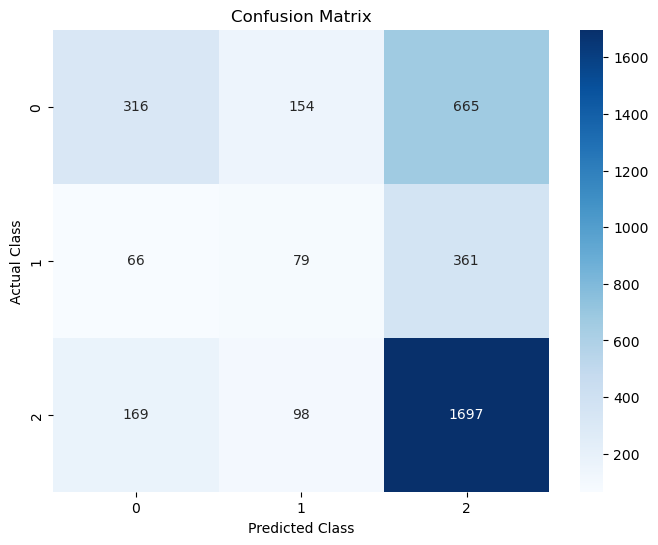

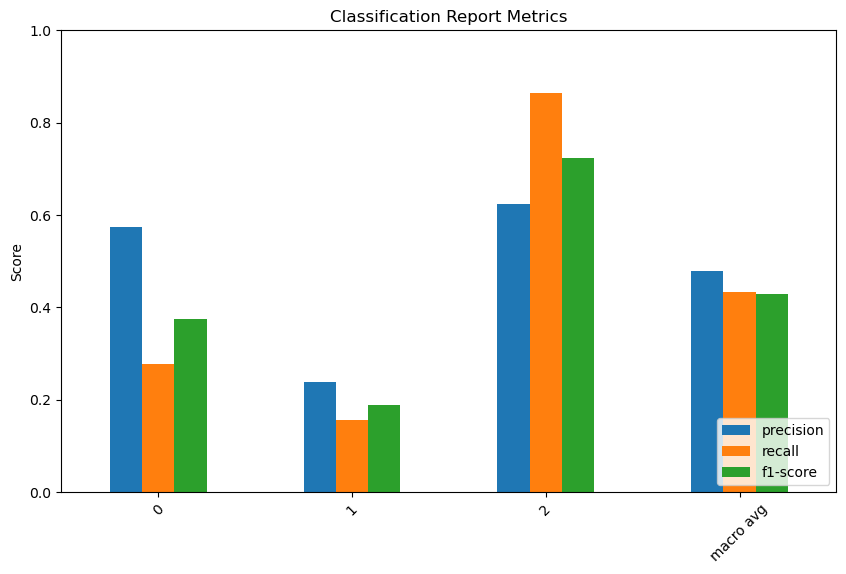

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Compute classification report
report = classification_report(results_df["Actual Class"], results_df["Predicted Class"], output_dict=True)

# Compute accuracy
accuracy = accuracy_score(results_df["Actual Class"], results_df["Predicted Class"])

print(f"Model Accuracy: {accuracy:.2%}")

# Plot confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(results_df["Actual Class"], results_df["Predicted Class"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(results_df["Actual Class"]), yticklabels=set(results_df["Actual Class"]))
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()

# Convert classification report to DataFrame for plotting
report_df = pd.DataFrame(report).transpose().drop(['accuracy'], errors='ignore')

# Plot precision, recall, and f1-score
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10,6))
plt.title("Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


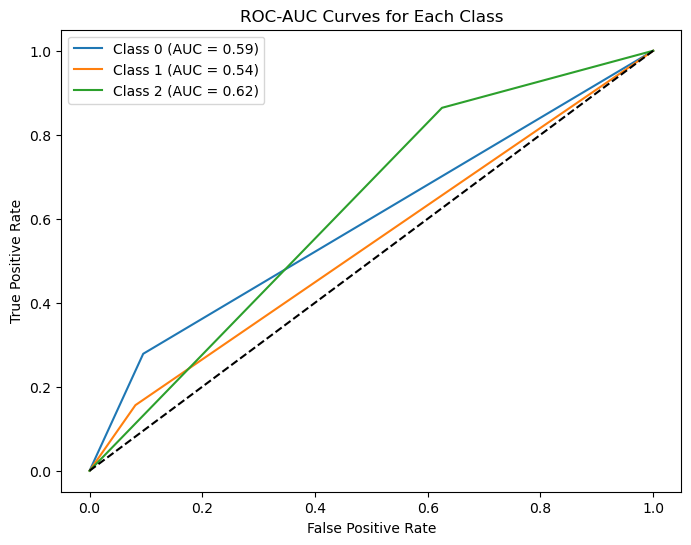

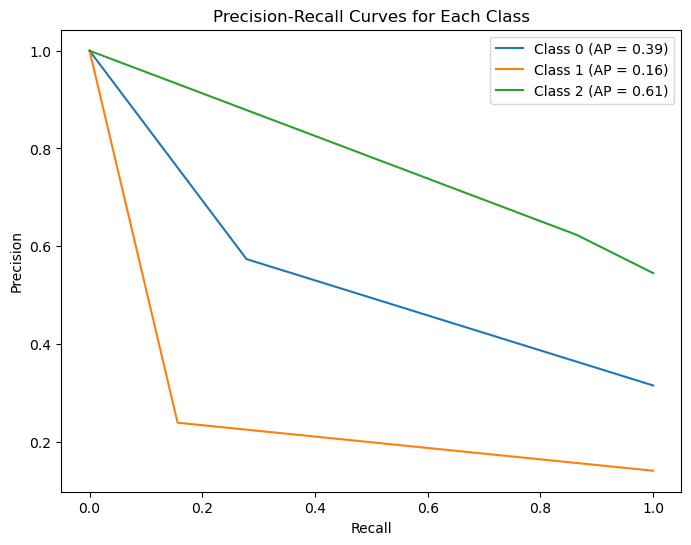

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize the actual class labels for multi-class ROC-AUC
classes = sorted(results_df["Actual Class"].unique())  # Get class labels
y_true = label_binarize(results_df["Actual Class"], classes=classes)
y_pred_proba = label_binarize(results_df["Predicted Class"], classes=classes)

# === Plot ROC-AUC Curve for Each Class ===
plt.figure(figsize=(8,6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random performance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curves for Each Class")
plt.legend()
plt.show()

# === Plot Precision-Recall Curve for Each Class ===
plt.figure(figsize=(8,6))
for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_true[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {class_label} (AP = {avg_precision:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Each Class")
plt.legend()
plt.show()


# **Tumor Classification Model Evaluation**

## **1. Model Performance Summary**
- **Model Accuracy**: 58.03%
- **Class Labels**:
  - **0 = Benign**
  - **1 = Malignant**
  - **2 = Normal**

## **2. ROC-AUC Curve Analysis**
The **ROC-AUC** scores show how well the model separates each class:

| Class | AUC Score | Interpretation |
|--------|----------|----------------|
| **Benign (0)** | 0.59 | Poor separation, slightly better than random guessing. |
| **Malignant (1)** | 0.54 | Almost random classification, model struggles to distinguish malignancy. |
| **Normal (2)** | 0.62 | Performs slightly better, but still weak. |

** Key Issue:** The model is **confused between benign and malignant tumors** and is slightly biased toward predicting "normal" tissue.

---

## **3. Precision-Recall Curve Analysis**
Precision-Recall curves help evaluate performance for **imbalanced data**:

| Class | AP Score | Interpretation |
|--------|----------|----------------|
| **Benign (0)** | 0.39 | Low confidence in benign tumor predictions. |
| **Malignant (1)** | 0.16 | Very poor performance—most malignant tumors are misclassified. |
| **Normal (2)** | 0.61 | Best performance, but still weak. |

** Key Issue:**  
- The model **often predicts normal (Class 2) incorrectly**, leading to **high false positives and false negatives**.
- **Malignant tumors (Class 1) are rarely detected correctly**, making this model unreliable for cancer detection.

---

## **4. Key Problems & Suggested Fixes**
### **Issue 1: Model Overpredicts "Normal" (Class 2)**
- **Why?** The dataset might have more normal images, causing **class imbalance**.
- **Fix:** Apply **oversampling (SMOTE), undersampling, or class weighting**.

### **Issue 2: Malignant Cases Are Misclassified (AP = 0.16)**
- **Why?** The model may not be extracting enough **malignant tumor features**.
- **Fix:** Try **transfer learning with ResNet, EfficientNet, or deeper CNNs**.

### **Issue 3: Poor Separation Between Tumor Types**
- **Why?** **Segmentation may not be accurate**, leading to **noisy input data**.
- **Fix:** Improve **tumor segmentation (fine-tune SAM, try U-Net, or better preprocessing techniques)**.

---

## **5. Next Steps for Model Improvement**
 **Balance dataset** → Ensure equal samples for **benign, malignant, and normal**.  
 **Improve feature extraction** → Use **transfer learning (ResNet, EfficientNet, or fine-tuning CNNs)**.  
 **Enhance segmentation quality** → Ensure tumor cropping is accurate for better feature learning.  

 **Goal:** Improve malignant tumor classification and **reduce misclassifications for benign cases**.

---

_This analysis highlights critical model weaknesses and provides steps to enhance tumor classification accuracy._


## Applying CNN to the cropped Images and Measuring Accuracy and Precision


In [6]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

#initializing the model 
model = tf.keras.models.load_model("tumor_classifier.h5")

#adding actual class label so that we can check accuracy of prediction
# Define the base directory containing the folders
base_dir = "/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Cropped_Tumors/val"

# Create a list to store the results
results = []

# Function to classify images based on filename and category
def classify_image(row):
    if row['Category'] == 'benign' and row['Image'].startswith('tumor'):
        return 0
    elif row['Category'] == 'malignant' and row['Image'].startswith('tumor'):
        return 1
    elif row['Image'].startswith('normal'):
        return 2
    return None  # Handle unexpected cases

# Loop through both "benign" and "malignant" folders
for category in ["benign", "malignant", "normal"]:
    category_path = os.path.join(base_dir, category)

    if not os.path.exists(category_path):
        print(f"Skipping {category}, folder not found.")
        continue  # Skip if folder does not exist

    # Iterate over images in the category folder
    for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)

        try:
            # Load and preprocess the image
            img = image.load_img(img_path, target_size=(128, 128))  # Resize
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Predict
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions)

            # Store results
            results.append({
                "Image": img_file,
                "Category": category,
                "Predicted Class": predicted_class
            })

        except Exception as e:
            print(f"Error processing {img_file}: {e}")

# Convert results into a DataFrame
results_df_cropped = pd.DataFrame(results)

# Apply the classify_image function to create the Actual Class column
results_df_cropped["Actual Class"] = results_df_cropped.apply(classify_image, axis=1)



/home/sobottka/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/sobottka/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [7]:
results_df_cropped

,Image,Category,Predicted Class,Actual Class
0,tumor_549_mask0.png,benign,0,0
1,tumor_719_mask0.png,benign,0,0
2,tumor_755_mask0.png,benign,0,0
3,tumor_906_mask1.png,benign,0,0
4,tumor_707_mask0.png,benign,0,0
...,...,...,...,...
240,normal_50_crop3.png,normal,2,2
241,normal_150_crop2.png,normal,2,2
242,normal_100.png,normal,2,2
243,normal_140_crop1.png,normal,2,2


## Compute Accuracy, Precision, Recall and F1-Score

In [9]:
from sklearn.metrics import classification_report, accuracy_score

# Compute classification report
report = classification_report(results_df_cropped["Actual Class"], results_df_cropped["Predicted Class"], digits=4)

# Compute accuracy
accuracy = accuracy_score(results_df_cropped["Actual Class"], results_df_cropped["Predicted Class"])

print(f"Model Accuracy: {accuracy:.2%}")
print("\nClassification Report:\n", report)


Model Accuracy: 88.98%

Classification Report:
               precision    recall  f1-score   support

           0     0.8553    0.8667    0.8609        75
           1     0.8182    0.7297    0.7714        37
           2     0.9265    0.9474    0.9368       133

    accuracy                         0.8898       245
   macro avg     0.8666    0.8479    0.8564       245
weighted avg     0.8883    0.8898    0.8886       245



Model Accuracy: 88.98%


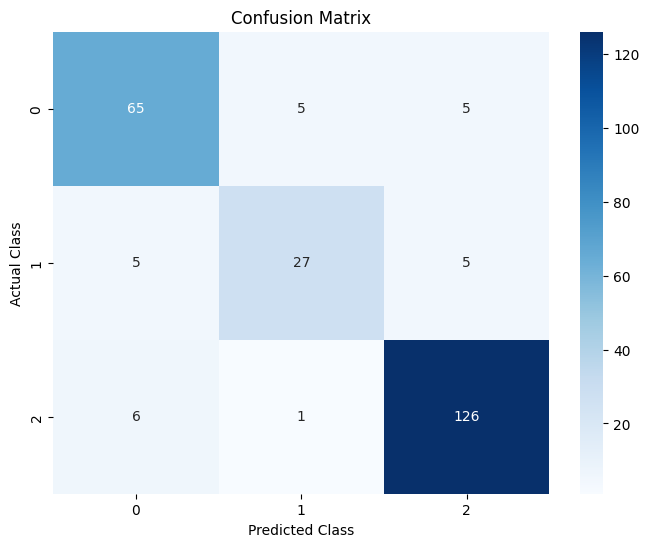

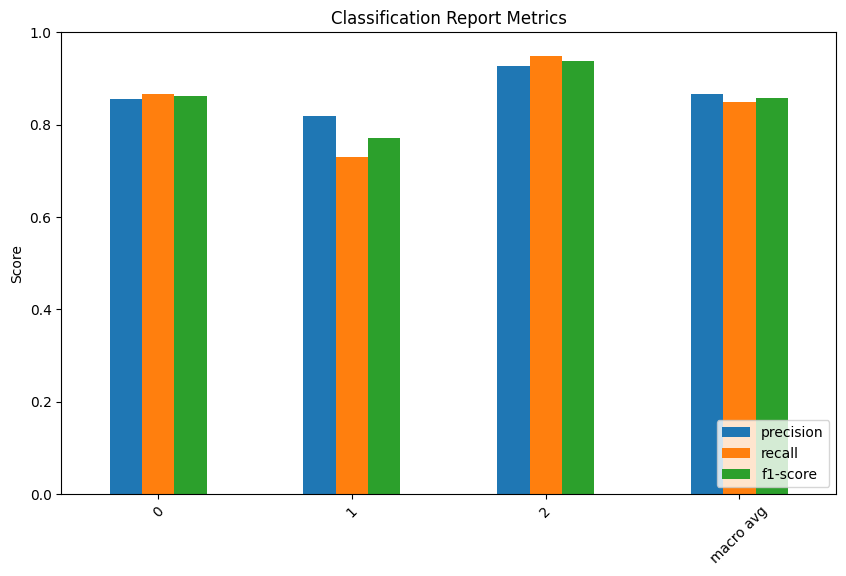

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Compute classification report
report = classification_report(results_df_cropped["Actual Class"], results_df_cropped["Predicted Class"], output_dict=True)

# Compute accuracy
accuracy = accuracy_score(results_df_cropped["Actual Class"], results_df_cropped["Predicted Class"])

print(f"Model Accuracy: {accuracy:.2%}")

# Plot confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(results_df_cropped["Actual Class"], results_df_cropped["Predicted Class"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(results_df_cropped["Actual Class"]), yticklabels=set(results_df_cropped["Actual Class"]))
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()

# Convert classification report to DataFrame for plotting
report_df = pd.DataFrame(report).transpose().drop(['accuracy'], errors='ignore')

# Plot precision, recall, and f1-score
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10,6))
plt.title("Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


# Classification Results Analysis for Cropped Images

## 1. Overall Accuracy (88.98%)

The model achieves a high overall accuracy, correctly classifying 88.98% of images. However, accuracy alone can be misleading, particularly in imbalanced datasets. Since the dataset is dominated by normal images (class 2), the model could achieve high accuracy by mostly predicting images as normal, without necessarily learning to distinguish tumors effectively.

## 2. Per-Class Performance

### Class 0 (Tumor Type 1)
- **Precision**: 0.8553 (85.5%) → When the model predicts class 0, it is correct 85.5% of the time.
- **Recall**: 0.8667 (86.7%) → The model correctly detects 86.7% of actual tumors in class 0.
- **F1-score**: 0.8609 → A balanced performance, indicating good precision and recall for this class.

### Class 1 (Tumor Type 2)
- **Precision**: 0.8182 (81.8%) → When the model predicts class 1, it is correct 81.8% of the time.
- **Recall**: 0.7297 (72.9%) → The model detects 72.9% of actual tumors in class 1.
- **F1-score**: 0.7714 → A moderate performance, but recall is lower than precision, meaning some tumors are still being missed.

### Class 2 (Normal)
- **Precision**: 0.9265 (92.6%) → When the model predicts "normal," it is correct most of the time.
- **Recall**: 0.9474 (94.7%) → The model correctly identifies normal cases nearly always.
- **F1-score**: 0.9368 → Strong performance for normal images, reinforcing the model’s ability to detect non-tumor cases.

## 3. Macro and Weighted Averages

### Macro avg
- **Precision**: 0.8666
- **Recall**: 0.8479
- **F1-score**: 0.8564
- These are unweighted averages across all classes.
- The recall (84.79%) suggests that, on average, the model detects a large portion of actual cases across all categories.

### Weighted avg
- **Precision**: 0.8883
- **Recall**: 0.8898
- **F1-score**: 0.8886
- These averages are weighted by class frequency.
- Since class 2 (normal) is dominant, these values may appear high but do not necessarily reflect true tumor detection capability.

## Key Takeaways

- The model demonstrates strong performance across all classes, particularly for normal images (class 2) and tumor type 1 (class 0).
- The recall for tumor type 2 (class 1) is lower than its precision, indicating that some cases may be missed.
- Unlike the previous model, which struggled with tumor detection, this model maintains relatively balanced performance for all classes.
- Further improvements could focus on increasing recall for class 1 to reduce the number of missed tumor cases, as missing tumors in a medical setting is critical.

